In [27]:
import pandas as pd  
import numpy as np
import ydata_profiling
import seaborn as sns
#import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                    cross_val_score
import os

In [28]:
filepath = os.path.abspath(".")
initial_df = pd.read_csv(rf'{filepath}\train.csv')
submission_df = pd.read_csv(rf'{filepath}\test.csv')

In [29]:
initial_df.dtypes


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Data preproccesing - Fill NaN values

In [30]:
initial_df['Age'] = initial_df['Age'].fillna(0)
# initial_df['Cabin'] = initial_df['Cabin'].fillna(0)
initial_df['Fare'] = initial_df['Fare'].fillna(0)

# transformer tous les champs en des numériques

In [31]:
features=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
initial_with_dummies_df = pd.get_dummies(initial_df[features + ['Survived']])

In [32]:
ydata_profiling.ProfileReport(initial_with_dummies_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

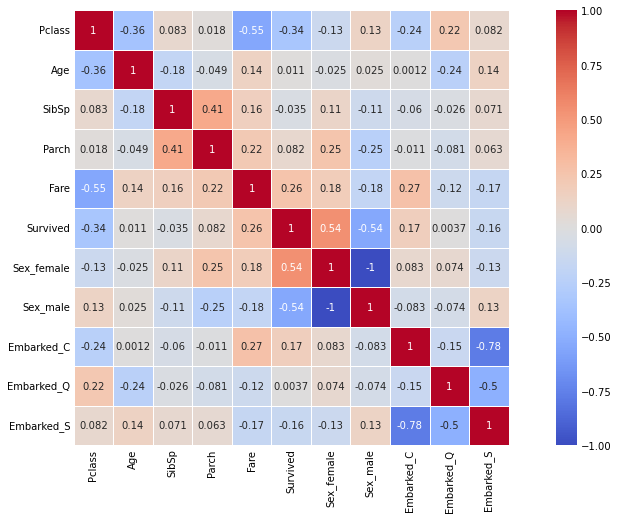

In [33]:
# Matrice des corrélations : 
cor = initial_with_dummies_df.corr() 

sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True)
plt.gcf().set_size_inches(15, 8)

#Pour choisr la couleur du heatmap : https://matplotlib.org/examples/color/colormaps_reference.html

Constats :

Corrélations avec la variable cible survived :

survived est correlé positivement avec sex_female (donc globalement quand l’indicateur sex_female augmente, survived augmente aussi)
survived est correlé négativement avec sex_male
En revanche pour les autres variables la corrélation est plus faible

Modélisation : Training Random Forest

In [34]:
#On stocke survived (la variable à prédire) dans cible
cible = np.array(initial_with_dummies_df['Survived'])
#On supprime survived du dataset
initial_with_dummies_df = initial_with_dummies_df.drop('Survived', axis = 1)
#On conserve les noms de variable à part
liste_variables = list(initial_with_dummies_df.columns)
#On convertit le dataset en array
initial_with_dummies_df = np.array(initial_with_dummies_df)

Split du dataset en train et test

In [35]:
#On créé 4 dataset : 
#   - x_train contient 75% de x  
#   - y_train contient le survived associé à x_train
# => x_train et y_train permettront d'entraîner l'algorithme
#
#   - x_test contient 25% de x  
#   - y_test contient le survived associé à x_test
# => x_test et y_test permettront d'évaluer la performance de l'algorithme une fois entrainé sur le train
x_train,x_test,y_train,y_test=train_test_split(initial_with_dummies_df,cible,test_size=0.25, shuffle=False, random_state=1)

Apprentissage

In [36]:
#On importe l'algorithme à partir de sklearn
from sklearn.ensemble import RandomForestRegressor
#On créé un Random Forest de 100 arbres 
rf = RandomForestRegressor(n_estimators = 100, random_state = 1)
#Et on lance le training sur notre dataset de train
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=1)

# Test

In [37]:
#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
predictions = rf.predict(x_test).round()
print(predictions)

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0.]


In [38]:
#On va calculer plusieurs erreurs entre la valeur prédite et le score de bonheur réel (que nous avions stocké dans y_test)
#     - MAE : Mean Asolute Error
#     - MAPE : Mean Absolute Percentage Error 
# MAE 
erreurs = abs(predictions - y_test)
print(y_test.mean())
print('Mean Absolute Error:', round(np.mean(erreurs), 2))

#deuxième méthode avec l'appel de la bibliothèque
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions).round(2)

0.36771300448430494
Mean Absolute Error: 0.17


0.17

Mean Absolute Error: 0.24
La moyenne des erreurs est de 0,24 donc en moyenne on arrive à prédire le score de bonheur à 0.24 près

In [39]:
# MAPE
mape = 100 * (erreurs / y_test)
print('Mean Absolute Percentage Error :', round(np.mean(mape), 2), '%.')

from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, predictions)
# the value when some element of the y_true is zero is arbitrarily high because
# of the division by epsilon

Mean Absolute Percentage Error : nan %.


C:\Users\Mo\AppData\Local\Temp\ipykernel_23128\4275970375.py:2: RuntimeWarning: divide by zero encountered in true_divide
  mape = 100 * (erreurs / y_test)
C:\Users\Mo\AppData\Local\Temp\ipykernel_23128\4275970375.py:2: RuntimeWarning: invalid value encountered in true_divide
  mape = 100 * (erreurs / y_test)


343323738409410.1

[8 7 9 3 2 0 6 5 1 4]


Text(0.5, 0, 'Relative Importance')

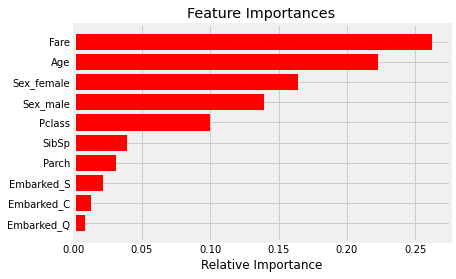

In [46]:
importances = rf.feature_importances_
indices = np.argsort(importances)
print(indices)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

In [41]:
cv_test = cross_val_score(rf, x_test, y_test, cv=5).mean().round(5)
model_score = rf.score(x_test, y_test).round(5)    

In [42]:
data={'Model':'RandomForestRegressor','Cross_Validation':cv_test,'Accuracy':model_score}
df=pd.DataFrame(data=data,index=[1])
df

,Model,Cross_Validation,Accuracy
1,RandomForestRegressor,0.3996,0.4382


# Matrice de confusion

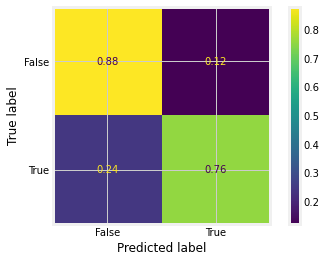

In [43]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predictions,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# Modèle erroné pour la classification